# Linear MAML on linear tasks

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from task_gen import TaskGenerator, DataGenerator

# Generate tasks

- A task $\tau_{i}$ is a data generation process that generates a dataset $D_i \sim \tau_{i}$ where the dataset is a collection of input and output pairs $\{x,y\}$. 

- Linear parametric case: the task $\tau_i$ corresponds to a set of weights $w_i \sim p(w)$. 

- The data is generated according to $y = w_i^{T}x + \epsilon$ where $\epsilon$ is IID noise. 


- In the 1D case, $w_i \in \mathbf{R}^2$, $y \in \mathbf{R}$, and $x \in \mathbf{R}^{2}$ where the first component of $x$ is always equal to 1. 

In [21]:
tasks = TaskGenerator(2)

In [22]:
weight_tasks = np.array([tasks.sample_task() for _ in range(500)])

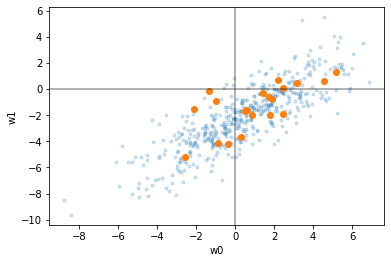

In [26]:
plt.plot(weight_tasks[:,0], weight_tasks[:,1], '.', alpha = .2)
plt.plot(weight_tasks[:20,0], weight_tasks[:20,1], 'o', 
         label = "Selected sample of tasks")
plt.axhline(0,  color = "k", alpha = .4)
plt.axvline(0,  color = "k", alpha = .4)
plt.xlabel("w0")
plt.ylabel("w1");


In [34]:
num_tasks = 100
X_trains, y_trains, X_tests, y_tests = [], [], [], []
w_stars = []
for i in range(num_tasks):
    data_gen = DataGenerator(weight=weight_tasks[i], d = 1)
    X_tr, y_tr = data_gen.sample_train(15)
    X_ts, y_ts = data_gen.sample_test(5)
    
    w_stars.append(weight_tasks[i])
    X_trains.append(X_tr)
    y_trains.append(y_tr)
    X_tests.append(X_ts)
    y_tests.append(y_ts)
    
    

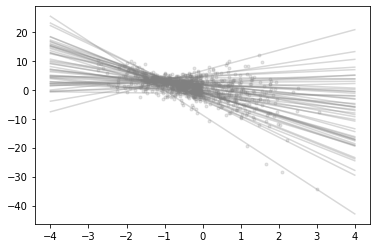

In [52]:
X_ = np.linspace(-4,4)
for i in range(50):
    plt.plot(X_trains[i][:,1], y_trains[i], '.', color = "gray", alpha = .2);
    plt.plot(X_tests[i][:,1], y_tests[i], '.', color = "gray", alpha = .2);
    plt.plot(X_, np.stack((np.ones_like(X_), X_)).T @ w_stars[i], color = "gray", alpha = .3)
    

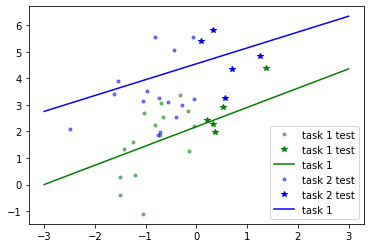

In [56]:
X_ = np.linspace(-3, 3)
plt.plot(X_trains[0][:,1], y_trains[0], '.', alpha = .5, color = "g", label = "task 1 test", )
plt.plot(X_tests[0][:,1], y_tests[0], '*', color = "g", label = "task 1 test", )
plt.plot(X_, w_stars[0][0] + w_stars[0][1]*X_, color = "g", label = "task 1")
plt.plot(X_trains[1][:,1], y_trains[1], '.', alpha = .5, color = "b", label = "task 2 test", )
plt.plot(X_tests[1][:,1], y_tests[1], '*', color = "b", label = "task 2 test", )
plt.plot(X_, w_stars[1][0] + w_stars[1][1]*X_, color = "b", label = "task 1")
plt.legend();

In [57]:
import seaborn as sns;

(-1.1039492414170224, 4.395943831878654)

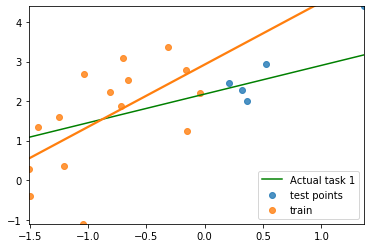

In [72]:
X_ = np.linspace(-3, 3)
plt.plot(X_, w_stars[0][0] + w_stars[0][1]*X_, color = "g", label = "Actual task 1")
sns.regplot(X_tests[0][:,1], y_tests[0], ci = None, fit_reg=False, label = "test points")
sns.regplot(X_trains[0][:,1], y_trains[0], ci = None, label = "train")
plt.legend(loc = "lower right");
plt.xlim([X_trains[0][:,1].min(),X_tests[0][:,1].max()])
plt.ylim([y_trains[0].min(),y_tests[0].max()])

# Single task MAML (overfitting experiment)

In [73]:
from single_task_maml import OverfitMetaLearn

In [82]:
w_init = np.random.randn(2)
alpha = .01
maml = OverfitMetaLearn(X_tr = X_trains[0], y_tr = y_trains[0], X_ts = X_tests[0], y_ts = y_tests[0], alpha = .0001,
                       second_order = (np.eye(2) - alpha * X_trains[0].T @ X_trains[0]), 
                       num_outer_loop_epochs = 10000, 
                       num_inner_loop_epochs=1, 
                       w = w_init)

In [83]:
%%time
maml.iterate()

CPU times: user 648 ms, sys: 22 ms, total: 670 ms
Wall time: 655 ms


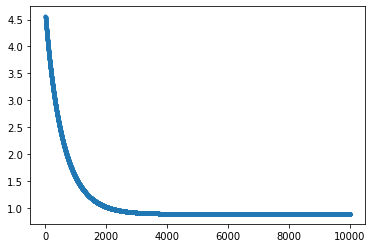

In [84]:
plt.plot(maml.mses, '.')

In [85]:
maml.mses[-1]

0.886412507416279

In [87]:
w_stars[0][0]

2.1777263247786407

In [89]:
maml.w

array([2.48223377, 1.15468481])

In [92]:
from sklearn.linear_model import LinearRegression

In [100]:
linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(np.vstack((X_trains[0], X_tests[0])),
               np.hstack((y_trains[0], y_tests[0])))

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

(-1.1039492414170224, 4.395943831878654)

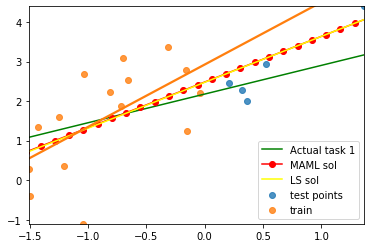

In [105]:
X_ = np.linspace(-3, 3)
plt.plot(X_, w_stars[0][0] + w_stars[0][1]*X_, color = "g", label = "Actual task 1")
plt.plot(X_, maml.w[0] + maml.w[1]*X_, 'o-', color = "red", label = "MAML sol")
plt.plot(X_, linear_reg.coef_[0] + linear_reg.coef_[1]*X_, color = "yellow", label = "LS sol")
sns.regplot(X_tests[0][:,1], y_tests[0], ci = None, fit_reg=False, label = "test points")
sns.regplot(X_trains[0][:,1], y_trains[0], ci = None, label = "train")
plt.legend(loc = "lower right");
plt.xlim([X_trains[0][:,1].min(),X_tests[0][:,1].max()])
plt.ylim([y_trains[0].min(),y_tests[0].max()])

In [106]:
from linear_maml import LinearMetaLearn

In [216]:
foml = LinearMetaLearn(X_trains = X_trains[0:50], y_trains = y_trains[0:20], X_tests = X_tests[0:50], y_tests = y_tests[0:20], alpha = .001,
                       second_order = True, 
                       num_outer_loop_epochs = 1000, 
                       num_inner_loop_epochs=1, w = np.random.randn(2))

In [217]:
%%time
foml.iterate()

CPU times: user 1.44 s, sys: 19 ms, total: 1.46 s
Wall time: 1.45 s


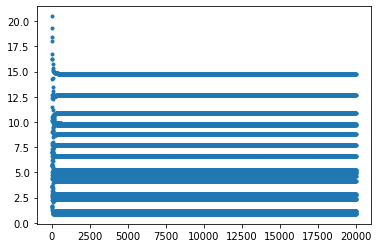

In [218]:
plt.plot(foml.mses, '.')

In [219]:
foml.w

array([ 0.9204401 , -1.52105935])

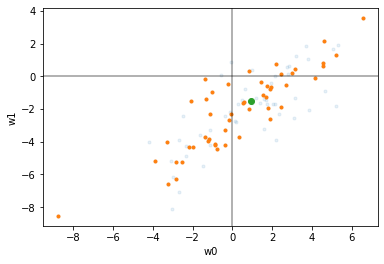

In [221]:
plt.plot(np.array(w_stars)[:,0], np.array(w_stars)[:,1], '.', alpha = .1);
plt.plot(np.array(w_stars)[:50,0], np.array(w_stars)[:50,1], '.');
plt.plot(foml.w[0], foml.w[1], 'o')
plt.axhline(0,  color = "k", alpha = .4)
plt.axvline(0,  color = "k", alpha = .4)
plt.xlabel("w0")
plt.ylabel("w1");

(-1.1039492414170224, 4.395943831878654)

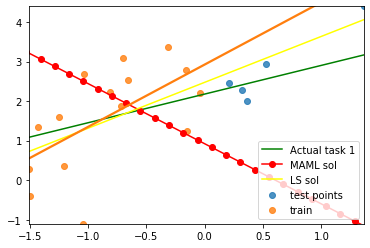

In [188]:
X_ = np.linspace(-3, 3)
plt.plot(X_, w_stars[0][0] + w_stars[0][1]*X_, color = "g", label = "Actual task 1")
plt.plot(X_, foml.w[0] + foml.w[1]*X_, 'o-', color = "red", label = "MAML sol")
plt.plot(X_, linear_reg.coef_[0] + linear_reg.coef_[1]*X_, color = "yellow", label = "LS sol")
sns.regplot(X_tests[0][:,1], y_tests[0], ci = None, fit_reg=False, label = "test points")
sns.regplot(X_trains[0][:,1], y_trains[0], ci = None, label = "train")
plt.legend(loc = "lower right");
plt.xlim([X_trains[0][:,1].min(),X_tests[0][:,1].max()])
plt.ylim([y_trains[0].min(),y_tests[0].max()])

In [201]:
foml.inner_loop_updates(X_trains[0], y_trains[0], num_epochs=1000)

(-1.1039492414170224, 4.395943831878654)

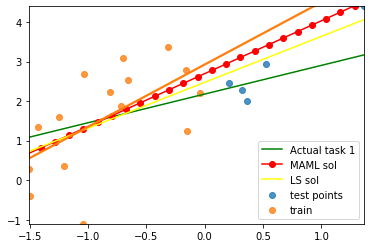

In [202]:
X_ = np.linspace(-3, 3)
plt.plot(X_, w_stars[0][0] + w_stars[0][1]*X_, color = "g", label = "Actual task 1")
plt.plot(X_, foml.w[0] + foml.w[1]*X_, 'o-', color = "red", label = "MAML sol")
plt.plot(X_, linear_reg.coef_[0] + linear_reg.coef_[1]*X_, color = "yellow", label = "LS sol")
sns.regplot(X_tests[0][:,1], y_tests[0], ci = None, fit_reg=False, label = "test points")
sns.regplot(X_trains[0][:,1], y_trains[0], ci = None, label = "train")
plt.legend(loc = "lower right");
plt.xlim([X_trains[0][:,1].min(),X_tests[0][:,1].max()])
plt.ylim([y_trains[0].min(),y_tests[0].max()])